In [1]:
from itertools import chain

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.layers import LSTM, Softmax
from tensorflow.keras.losses import Hinge, SquaredHinge

In [2]:
# Hyperparams

# Note: Window size needs to be at least 4 for kurtosis to work
WINDOW_SIZE = 4
NUM_INPUTS = 16
NUM_CLASSES = 3

In [3]:
data = pd.read_csv("daily_eur_usd.csv").iloc[::-1].reset_index(drop=True)

In [4]:
data

,date,open,high,low,close
0,2002-01-28,0.8630,0.8663,0.8567,0.8610
1,2002-01-29,0.8611,0.8656,0.8587,0.8644
2,2002-01-30,0.8642,0.8674,0.8597,0.8614
3,2002-01-31,0.8613,0.8646,0.8575,0.8579
4,2002-02-01,0.8586,0.8642,0.8560,0.8614
...,...,...,...,...,...
4995,2021-03-23,1.1934,1.1941,1.1840,1.1849
4996,2021-03-24,1.1849,1.1852,1.1808,1.1812
4997,2021-03-25,1.1812,1.1828,1.1760,1.1768
4998,2021-03-26,1.1768,1.1805,1.1766,1.1793


In [5]:
# Use only open prices for now
#data.drop(columns=["high", "low", "close"], inplace=True)

In [6]:
open_skew = data.rolling(window=WINDOW_SIZE).skew(axis=1).rename(columns={
    "open": "rolling_open_skew",
    "high": "rolling_high_skew",
    "low": "rolling_low_skew",
    "close": "rolling_close_skew",
})
open_skew

,rolling_open_skew,rolling_high_skew,rolling_low_skew,rolling_close_skew
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,0.526770,0.112227,0.164218,-5.598435e-02
4,0.260613,1.112654,-0.377707,-2.813838e-01
...,...,...,...,...
4995,0.449674,1.828714,-0.057364,-1.333771e+00
4996,-0.271693,-1.949799,-0.840696,-1.629631e-01
4997,0.430127,-0.124395,-0.394758,7.397104e-01
4998,0.768187,1.402847,0.564940,4.673598e-01


In [7]:
open_kurt = data.rolling(window=WINDOW_SIZE).kurt(axis=1).rename(columns={
    "open": "rolling_open_kurtosis",
    "high": "rolling_high_kurtosis",
    "low": "rolling_low_kurtosis",
    "close": "rolling_close_kurtosis",
})
open_kurt

,rolling_open_kurtosis,rolling_high_kurtosis,rolling_low_kurtosis,rolling_close_kurtosis
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,-2.886462,-0.149918,-2.024956,1.389041
4,1.500000,0.501027,-0.919941,1.544052
...,...,...,...,...
4995,0.340311,3.405999,1.494511,2.335829
4996,-1.657251,3.838190,-1.354082,-2.749314
4997,-0.044676,-5.192898,-0.408757,0.566419
4998,0.628257,2.093259,-2.624749,0.199430


In [8]:
open_dev = data.rolling(window=WINDOW_SIZE).std().rename(columns={
    "open": "rolling_open_std",
    "high": "rolling_high_std",
    "low": "rolling_low_std",
    "close": "rolling_close_std",
})
open_dev

,rolling_open_std,rolling_high_std,rolling_low_std,rolling_close_std
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,0.001472,0.001179,0.001320,0.002659
4,0.002291,0.001427,0.001595,0.002658
...,...,...,...,...
4995,0.004200,0.002402,0.002613,0.003551
4996,0.003717,0.004502,0.003090,0.005395
4997,0.005162,0.006089,0.004814,0.006955
4998,0.007043,0.005951,0.003764,0.003414


In [9]:
data2 = pd.concat([data, open_skew, open_kurt, open_dev], axis=1)
data2

,date,open,high,low,close,rolling_open_skew,rolling_high_skew,rolling_low_skew,rolling_close_skew,rolling_open_kurtosis,rolling_high_kurtosis,rolling_low_kurtosis,rolling_close_kurtosis,rolling_open_std,rolling_high_std,rolling_low_std,rolling_close_std
0,2002-01-28,0.8630,0.8663,0.8567,0.8610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-29,0.8611,0.8656,0.8587,0.8644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-01-30,0.8642,0.8674,0.8597,0.8614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-01-31,0.8613,0.8646,0.8575,0.8579,0.526770,0.112227,0.164218,-5.598435e-02,-2.886462,-0.149918,-2.024956,1.389041,0.001472,0.001179,0.001320,0.002659
4,2002-02-01,0.8586,0.8642,0.8560,0.8614,0.260613,1.112654,-0.377707,-2.813838e-01,1.500000,0.501027,-0.919941,1.544052,0.002291,0.001427,0.001595,0.002658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2021-03-23,1.1934,1.1941,1.1840,1.1849,0.449674,1.828714,-0.057364,-1.333771e+00,0.340311,3.405999,1.494511,2.335829,0.004200,0.002402,0.002613,0.003551
4996,2021-03-24,1.1849,1.1852,1.1808,1.1812,-0.271693,-1.949799,-0.840696,-1.629631e-01,-1.657251,3.838190,-1.354082,-2.749314,0.003717,0.004502,0.003090,0.005395
4997,2021-03-25,1.1812,1.1828,1.1760,1.1768,0.430127,-0.124395,-0.394758,7.397104e-01,-0.044676,-5.192898,-0.408757,0.566419,0.005162,0.006089,0.004814,0.006955
4998,2021-03-26,1.1768,1.1805,1.1766,1.1793,0.768187,1.402847,0.564940,4.673598e-01,0.628257,2.093259,-2.624749,0.199430,0.007043,0.005951,0.003764,0.003414


In [10]:
data["open"].pct_change().max()

0.03795620437956204

In [11]:
def iterate_pairs(df, f):
    memory = None
    for idx, row in df.iterrows():
        item = row["open"]
        yield f(memory, item)
        memory = item

In [12]:
def decide_buy_sell(old, new):
    if old is None:
        return 0
    if abs(old - new) < 0.001:
        return 0
    if old < new:
        return -1
    if new < old:
        return 1
    
buy_sell_df = pd.DataFrame(list(iterate_pairs(data, decide_buy_sell)), columns=["buy/sell"])
buy_sell_df

,buy/sell
0,0
1,1
2,-1
3,1
4,1
...,...
4995,-1
4996,1
4997,1
4998,1


In [13]:
display = pd.concat([data, buy_sell_df], axis=1)
display

,date,open,high,low,close,buy/sell
0,2002-01-28,0.8630,0.8663,0.8567,0.8610,0
1,2002-01-29,0.8611,0.8656,0.8587,0.8644,1
2,2002-01-30,0.8642,0.8674,0.8597,0.8614,-1
3,2002-01-31,0.8613,0.8646,0.8575,0.8579,1
4,2002-02-01,0.8586,0.8642,0.8560,0.8614,1
...,...,...,...,...,...,...
4995,2021-03-23,1.1934,1.1941,1.1840,1.1849,-1
4996,2021-03-24,1.1849,1.1852,1.1808,1.1812,1
4997,2021-03-25,1.1812,1.1828,1.1760,1.1768,1
4998,2021-03-26,1.1768,1.1805,1.1766,1.1793,1


In [14]:
# Get the longest consecutive "same decision"
holder = buy_sell_df.copy(deep=True)
holder["indicator"] = buy_sell_df["buy/sell"].diff().ne(0).cumsum()

sizes=holder.groupby('indicator')['buy/sell'].transform('size')
display[sizes == sizes.max()]

,date,open,high,low,close,buy/sell
3854,2016-11-07,1.1084,1.1110,1.1025,1.1043,1
3855,2016-11-08,1.1043,1.1067,1.1006,1.1013,1
3856,2016-11-09,1.1013,1.1300,1.0904,1.0919,1
3857,2016-11-10,1.0920,1.0954,1.0862,1.0885,1
3858,2016-11-11,1.0886,1.0924,1.0829,1.0852,1
3859,2016-11-14,1.0838,1.0840,1.0707,1.0744,1
3860,2016-11-15,1.0744,1.0817,1.0711,1.0724,1
3861,2016-11-16,1.0724,1.0759,1.0664,1.0701,1
3862,2016-11-17,1.0699,1.0746,1.0617,1.0626,1
3863,2016-11-18,1.0626,1.0643,1.0567,1.0584,1


In [15]:
# Time to build a model; we want to predict our buy/sell choices from above
X, Y = data2.drop(columns=["date"]), buy_sell_df["buy/sell"]

In [16]:
X

,open,high,low,close,rolling_open_skew,rolling_high_skew,rolling_low_skew,rolling_close_skew,rolling_open_kurtosis,rolling_high_kurtosis,rolling_low_kurtosis,rolling_close_kurtosis,rolling_open_std,rolling_high_std,rolling_low_std,rolling_close_std
0,0.8630,0.8663,0.8567,0.8610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.8611,0.8656,0.8587,0.8644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.8642,0.8674,0.8597,0.8614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.8613,0.8646,0.8575,0.8579,0.526770,0.112227,0.164218,-5.598435e-02,-2.886462,-0.149918,-2.024956,1.389041,0.001472,0.001179,0.001320,0.002659
4,0.8586,0.8642,0.8560,0.8614,0.260613,1.112654,-0.377707,-2.813838e-01,1.500000,0.501027,-0.919941,1.544052,0.002291,0.001427,0.001595,0.002658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.1934,1.1941,1.1840,1.1849,0.449674,1.828714,-0.057364,-1.333771e+00,0.340311,3.405999,1.494511,2.335829,0.004200,0.002402,0.002613,0.003551
4996,1.1849,1.1852,1.1808,1.1812,-0.271693,-1.949799,-0.840696,-1.629631e-01,-1.657251,3.838190,-1.354082,-2.749314,0.003717,0.004502,0.003090,0.005395
4997,1.1812,1.1828,1.1760,1.1768,0.430127,-0.124395,-0.394758,7.397104e-01,-0.044676,-5.192898,-0.408757,0.566419,0.005162,0.006089,0.004814,0.006955
4998,1.1768,1.1805,1.1766,1.1793,0.768187,1.402847,0.564940,4.673598e-01,0.628257,2.093259,-2.624749,0.199430,0.007043,0.005951,0.003764,0.003414


In [17]:
Y

0       0
1       1
2      -1
3       1
4       1
       ..
4995   -1
4996    1
4997    1
4998    1
4999   -1
Name: buy/sell, Length: 5000, dtype: int64

In [18]:
# Make rolling window inputs
def prepare_inputs(X):
    def make_rolling_window_inputs(df):
        cnt = 0
        for x in df.rolling(window=WINDOW_SIZE):
            cnt += 1
            if cnt < WINDOW_SIZE:
                continue
            yield pd.array(list(chain.from_iterable(x.values)))

    # Arcane wizardry from: https://stackoverflow.com/questions/55126339/how-to-flatten-array-in-pandas-dataframe
    out = pd.Series(list(chain.from_iterable(make_rolling_window_inputs(X)))).fillna(float('NaN'))
    return out.values.reshape(len(out) // (WINDOW_SIZE * NUM_INPUTS), NUM_INPUTS, WINDOW_SIZE)
final_out = np.asarray(prepare_inputs(X)).astype('float32')
final_out

array([[[ 8.62999976e-01,  8.66299987e-01,  8.56700003e-01,
          8.61000001e-01],
        [            nan,             nan,             nan,
                     nan],
        [            nan,             nan,             nan,
                     nan],
        ...,
        [ 5.26770115e-01,  1.12226605e-01,  1.64218143e-01,
         -5.59843443e-02],
        [-2.88646173e+00, -1.49918407e-01, -2.02495623e+00,
          1.38904059e+00],
        [ 1.47196010e-03,  1.17862911e-03,  1.32035348e-03,
          2.65879044e-03]],

       [[ 8.61100018e-01,  8.65599990e-01,  8.58699977e-01,
          8.64400029e-01],
        [            nan,             nan,             nan,
                     nan],
        [            nan,             nan,             nan,
                     nan],
        ...,
        [ 2.60613292e-01,  1.11265385e+00, -3.77706677e-01,
         -2.81383753e-01],
        [ 1.50000012e+00,  5.01026809e-01, -9.19940710e-01,
          1.54405200e+00],
        [ 2.290

In [19]:
final_out.shape

(4997, 16, 4)

In [20]:
final_out[3]

array([[ 8.61299992e-01,  8.64600003e-01,  8.57500017e-01,
         8.57900023e-01],
       [ 5.26770115e-01,  1.12226605e-01,  1.64218143e-01,
        -5.59843443e-02],
       [-2.88646173e+00, -1.49918407e-01, -2.02495623e+00,
         1.38904059e+00],
       [ 1.47196010e-03,  1.17862911e-03,  1.32035348e-03,
         2.65879044e-03],
       [ 8.58600020e-01,  8.64199996e-01,  8.56000006e-01,
         8.61400008e-01],
       [ 2.60613292e-01,  1.11265385e+00, -3.77706677e-01,
        -2.81383753e-01],
       [ 1.50000012e+00,  5.01026809e-01, -9.19940710e-01,
         1.54405200e+00],
       [ 2.29056040e-03,  1.42711832e-03,  1.59452192e-03,
         2.65753642e-03],
       [ 8.61999989e-01,  8.71100008e-01,  8.60300004e-01,
         8.70000005e-01],
       [-3.13658953e-01,  1.01476145e+00, -3.90353590e-01,
         1.36305702e+00],
       [ 1.10740399e+00, -3.58408779e-01, -3.01628160e+00,
         2.57395053e+00],
       [ 2.30849884e-03,  3.18577560e-03,  1.98892760e-03,
      

In [21]:
def make_onehot(idx):
    res = np.zeros(NUM_CLASSES)
    res[idx] = 1
    return res

# Make it range from [0,3] rather than [-1,1]
final_labels = Y.add(1)
final_labels = final_labels.apply(lambda x: make_onehot(x))
final_labels = pd.array(list(chain.from_iterable(final_labels.values)))


In [22]:
final_labels = np.asarray(final_labels).astype('float32').reshape(len(final_labels) // (NUM_CLASSES), NUM_CLASSES)

In [23]:
final_out[-1:]

array([[[ 1.1849000e+00,  1.1852000e+00,  1.1808000e+00,  1.1812000e+00],
        [-2.7169311e-01, -1.9497991e+00, -8.4069633e-01, -1.6296309e-01],
        [-1.6572506e+00,  3.8381903e+00, -1.3540820e+00, -2.7493145e+00],
        [ 3.7169657e-03,  4.5021293e-03,  3.0901725e-03,  5.3952914e-03],
        [ 1.1812000e+00,  1.1828001e+00,  1.1760000e+00,  1.1768000e+00],
        [ 4.3012661e-01, -1.2439550e-01, -3.9475828e-01,  7.3971039e-01],
        [-4.4676270e-02, -5.1928978e+00, -4.0875736e-01,  5.6641853e-01],
        [ 5.1622833e-03,  6.0887877e-03,  4.8141284e-03,  6.9552739e-03],
        [ 1.1768000e+00,  1.1805000e+00,  1.1766000e+00,  1.1793000e+00],
        [ 7.6818657e-01,  1.4028474e+00,  5.6493956e-01,  4.6735984e-01],
        [ 6.2825692e-01,  2.0932596e+00, -2.6247487e+00,  1.9943015e-01],
        [ 7.0433775e-03,  5.9511904e-03,  3.7643060e-03,  3.4141862e-03],
        [ 1.1787000e+00,  1.1791000e+00,  1.1773000e+00,  1.1787000e+00],
        [ 6.2327480e-01,  4.1593656e-0

In [24]:
final_labels.shape

(5000, 3)

In [25]:
# Had some nan loss issues (I think exploding gradients)
# Some useful tips: https://datascience.stackexchange.com/questions/68331/keras-sequential-model-returns-loss-nan

model = Sequential()
model.add(LSTM(80, activation='relu', kernel_regularizer='l2', input_shape=(NUM_INPUTS,WINDOW_SIZE)))
model.add(Dense(100, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='relu', kernel_regularizer='l2'))
model.add(Softmax())
model.compile(optimizer='adam', loss=SquaredHinge(), metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 80)                27200     
_________________________________________________________________
dense (Dense)                (None, 100)               8100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
_________________________________________________________________
softmax (Softmax)            (None, 3)                 0

In [26]:
history = model.fit(final_out[3:], final_labels[6:], epochs=75, validation_split=0.2, batch_size=50)

Epoch 1/75
80/80 [==============================] - 10s 74ms/step - loss: 2.8221 - accuracy: 0.4059 - val_loss: 1.8249 - val_accuracy: 0.4775
Epoch 2/75
80/80 [==============================] - 4s 53ms/step - loss: 1.6707 - accuracy: 0.4425 - val_loss: 1.4522 - val_accuracy: 0.4014
Epoch 3/75
80/80 [==============================] - 4s 51ms/step - loss: 1.3974 - accuracy: 0.4503 - val_loss: 1.3563 - val_accuracy: 0.4665
Epoch 4/75
80/80 [==============================] - 4s 52ms/step - loss: 1.3282 - accuracy: 0.4510 - val_loss: 1.3338 - val_accuracy: 0.4254
Epoch 5/75
80/80 [==============================] - 4s 52ms/step - loss: 1.3062 - accuracy: 0.4718 - val_loss: 1.3271 - val_accuracy: 0.4094
Epoch 6/75
80/80 [==============================] - 4s 46ms/step - loss: 1.2961 - accuracy: 0.4512 - val_loss: 1.3138 - val_accuracy: 0.4464
Epoch 7/75
80/80 [==============================] - 4s 47ms/step - loss: 1.2801 - accuracy: 0.4822 - val_loss: 1.3028 - val_accuracy: 0.4565
Epoch 8/75
8

In [27]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


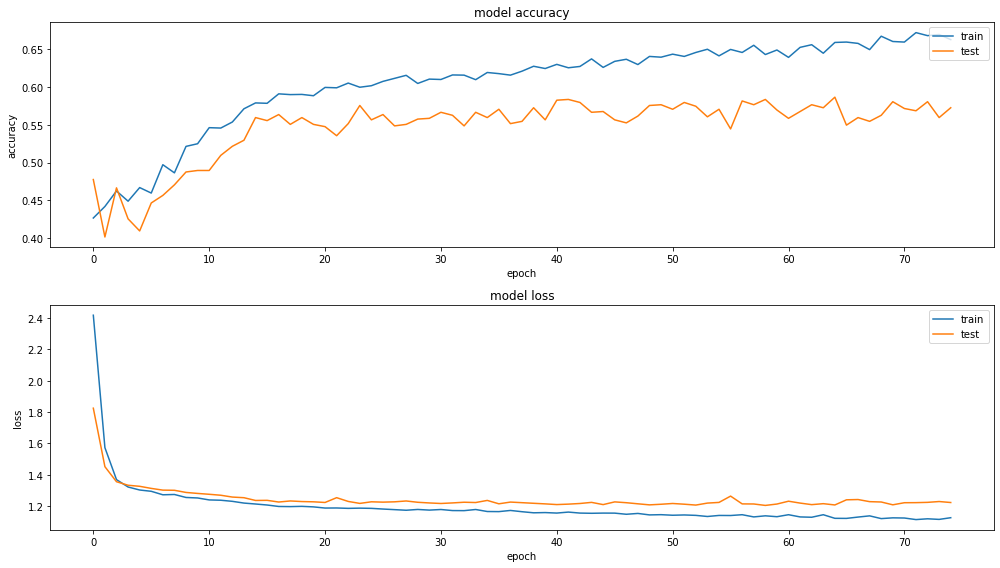

In [28]:
# https://www.codesofinterest.com/2017/03/graph-model-training-history-keras.html

plt.figure(1, figsize=(14,8))  
   
# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
plt.show()  

In [29]:
model.predict(final_out[-25:])

array([[9.6474475e-01, 1.7627669e-02, 1.7627669e-02],
       [7.0389807e-02, 4.1981563e-02, 8.8762861e-01],
       [5.8119118e-01, 1.3129219e-01, 2.8751668e-01],
       [9.1703904e-01, 3.8844857e-02, 4.4116139e-02],
       [4.0987008e-03, 3.8324844e-03, 9.9206877e-01],
       [2.6097241e-01, 6.8563059e-02, 6.7046452e-01],
       [4.4265436e-03, 4.1157063e-03, 9.9145776e-01],
       [7.7347559e-01, 8.2505986e-02, 1.4401838e-01],
       [3.3641458e-03, 3.1871509e-03, 9.9344867e-01],
       [2.9091144e-03, 2.7827388e-03, 9.9430817e-01],
       [6.9023252e-02, 4.8506897e-02, 8.8246983e-01],
       [9.6652168e-01, 1.6739205e-02, 1.6739205e-02],
       [9.2720622e-01, 3.4795318e-02, 3.7998475e-02],
       [9.9773252e-01, 1.1337344e-03, 1.1337344e-03],
       [8.7110894e-03, 7.7235135e-03, 9.8356539e-01],
       [2.9381233e-01, 1.1072101e-01, 5.9546667e-01],
       [8.0095164e-02, 4.9105894e-02, 8.7079895e-01],
       [6.0241103e-02, 4.3870524e-02, 8.9588839e-01],
       [7.9048127e-02, 5.498